# Imports

In [1]:

%matplotlib inline
import collections
from typing import (
    Any, Dict, List, Optional, Mapping, Set, TypeVar, Tuple, Union,
)
import tensorflow as tf
import numpy as np
import scipy.special
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14
import xarray
import sys, os

import random

my_seed = 43
random.seed(my_seed)
np.random.seed(my_seed)
tf.random.set_seed(my_seed)

from mylayers import stable_time_step,conv2d_van, TimeDLayer_LC, Euler


tf.__version__, tf.keras.__version__



('2.2.1', '2.3.0-tf')

In [2]:
tf.keras.backend.set_floatx('float64')

# Load my data

In [3]:
my_concentration_np = np.load('my_train_input384_superbee.npy') #'my_train_input384.npy', # my_train_input384_superbee.npy
my_train_output_np = np.load('my_train_output384_superbee.npy') #'my_train_output384.npy',my_train_output384_superbee.npy

my_concentration = tf.convert_to_tensor(my_concentration_np)
my_train_output = tf.convert_to_tensor(my_train_output_np)

del my_concentration_np; del my_train_output_np

my_concentration.shape,my_train_output.shape

(TensorShape([5670, 48]), TensorShape([5670, 4, 48]))

In [4]:
my_train_output4 = tf.transpose(my_train_output,perm=[0,2,1])
my_train_output4.shape

TensorShape([5670, 48, 4])

# Set common names as inputs: concentration1,train_output4

In [5]:
concentration1 = my_concentration
train_output4=my_train_output4

## Hybrid Model - LC

In [17]:
class HybridModelLC(tf.keras.Model):
    def __init__(self,quantum_steps,grid_step, velocity,  courant=0.5,
                 num_layers=4,filters=32,kernel_size=(3,1),**kwargs):
        
        super().__init__()
        
        self.quantum_steps = quantum_steps
        self.grid_step =tf.cast(grid_step,dtype=tf.float64) 
        self.time_step = tf.cast(stable_time_step(velocity,self.grid_step,courant),dtype=tf.float64)
        
        self.trainable_part = conv2d_van(1,num_layers,filters, kernel_size,**kwargs)
        
        self.layer2 = TimeDLayer_LC(grid_step = self.grid_step,constant_velocity=velocity,time_step = self.time_step)
        self.layer3 = Euler(time_step = self.time_step)
        
        
    def call(self,inputs): #inputs here is cell_averages snapshot (C^old_\forall {i})
        inputs = tf.cast(inputs,dtype=tf.float64)
        
        def call_full(inps):
            field_snapshot = inps 
         
            x=self.layer2(field_snapshot) # time_derivatives snapshots

            new_field_snapshot=self.layer3([x,field_snapshot]) 

            h =tf.shape(new_field_snapshot)[0]; w= tf.shape(new_field_snapshot)[1];
            nn_correction = tf.reshape(self.trainable_part(tf.expand_dims(tf.expand_dims(new_field_snapshot,axis=-1),axis=-1)),shape=[h,w])  # shape=(batch_size,32,1,basis_size)          
            
            self.corrections_single = nn_correction #just for printing corrections
            
            
            corrected_new_field_snapshot = new_field_snapshot + nn_correction 
            
            
            return corrected_new_field_snapshot
    
        
        inps = inputs
        results =[]
        self.corrections_mult = []
        
        
        for quantum_step in range(self.quantum_steps):
            ## =======full model============|
            result = call_full(inps) 
            results.append(result)
            self.corrections_mult.append(self.corrections_single)

            inps = result #outputs rho^(n+1)_for-every-i 


        ## ===================================================
            
        final_res = tf.stack(results, axis=-1)
        self.corrects = tf.stack(self.corrections_mult,axis=-1)
            
        return final_res

# Instantiate the hybrid model

In [26]:
random.seed(my_seed)
np.random.seed(my_seed)
tf.random.set_seed(my_seed)

wrapper = HybridModelLC(quantum_steps = 4,grid_step=8,velocity=1.,
                        num_layers=4,filters=32,kernel_size=(3,1))

# ---------------------------------------------------------------------------------------------------------

# Other useful functionalities

### Create a custom callback for the validating runs:
#### see sec 3.4 in thesis: "Early stopping strategy"

In [27]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, real_tensor,file_path, frequency=3, tolerance=0.01, start_timestep=10,quantum_steps=wrapper.quantum_steps):
        super().__init__()
        self.real_tensor = real_tensor
        self.frequency = frequency
        self.tolerance = tolerance
        self.start_timestep = start_timestep
        self.time_steps = np.arange(0,1*196+1)
        self.quantum_steps = quantum_steps
        self.mae_differences = []  
        self.file_path = file_path
        
    def on_epoch_end(self, epoch, logs=None):
        each = int(concentration1.shape[0]/4)
        save_list = []
        if (epoch + 1) % self.frequency == 0:
            

            processed_predictions,resulting_corrects= forward_in_time(initial_state = concentration1[0:30], time_steps = self.time_steps,quantum_steps=self.quantum_steps) #129)  # Your additional processing


            # Calculate MAE for each timestep
            mae_per_timestep = tf.reduce_mean(tf.keras.losses.mean_absolute_error(
                self.real_tensor, processed_predictions), axis=1)

            # Check if MAEs are almost horizontal starting from the 10th timestep
            mae_from_start = mae_per_timestep[self.start_timestep:]
            max_min = tf.reduce_max(mae_from_start) - tf.reduce_min(mae_from_start)
            
            self.mae_differences.append(max_min.numpy())
            
            if  max_min < self.tolerance:
                print(f"Stopping training at epoch {epoch + 1} as MAE is almost horizontal from timestep {self.start_timestep}.")
                self.model.stop_training = True
                
                
    def on_train_end(self, logs=None):
        # Save the mae_differences to a file at the end of training
        with open(self.file_path, 'w') as f:
            for diff in self.mae_differences:
                f.write(f"{diff}\n")

In [28]:
## LOAD THE DATA FROM THE PURE NUMERICAL SOLVERS

high_res = np.load('high_res_simul384_superbee.npy')
low_res = np.load('low_res_simul384_superbee.npy')
high_res.shape, low_res.shape

((3073, 30, 48), (3073, 30, 48))

In [29]:
## INSTANTIATE THE CUSTOM CALLBACK

file_path = "../MAEtracking/advection_LC/mae_lr3e3_3e4_b64_q4_l4_f32_k3.dat"

custom_callback = CustomCallback(real_tensor=high_res[:197],
                                 file_path = file_path,
                                 frequency=1, 
                                 tolerance=1e-5,
                                 quantum_steps=4)
high_res[:197].shape


(197, 30, 48)

### Iterator in time

In [30]:
# def forward_in_time(initial_state:tf.Tensor, time_steps:np.array,quantum_steps:int=3):
#     '''
#     Uses our trained model to make predictions in time.
#     Args: 
#     initial_state: the snapshot of the field @ t=0
#     time_steps: number of time steps we want to go forward in time
#     quantum_steps: number of snapshots produced by our model for every single input instance.
#     p.e. input:(3750,32) --> output:(3750,32,quantum_steps)=(3750,32,4)
    
#     '''
    
#     res_list=[]
#     correct_list =[]
#     initial_state0 = tf.expand_dims(initial_state,axis=-1) # snapshot @ t=0 is saved here
    
#     for time_step in range(0,len(time_steps)-quantum_steps,quantum_steps):
        
#         prediction_for_every_time_step = wrapper(initial_state)
        
#         res_list.append(prediction_for_every_time_step) 
#         correct_list.append(wrapper.corrects)
        
#         initial_state = prediction_for_every_time_step[:,:,-1] #the last snapshot is used
        
    
#     stacked_res = tf.concat(res_list,axis=-1) 
#     corrects_fin = tf.concat(correct_list,axis=-1)
    
#     stacked2 = tf.concat([initial_state0,stacked_res],axis=-1) # concat the snapshot @t=0 (known as input)
        
#     stacked3 = tf.transpose(stacked2,perm = [2,0,1]) 
    
#     return stacked3,corrects_fin


In [31]:
def forward_in_time(initial_state:tf.Tensor, time_steps:np.array,quantum_steps:int=3):
    '''
    FOR THE 1D ADVECTION EQUATION: Uses our hybrid LI trained model to make predictions in time
    and to also output the coefficients that are produced by the CNN to compute the spatial derivatives.
    Args: 
    initial_state: the snapshot of the field @ t=0
    time_steps: number of time steps we want to go forward in time
    quantum_steps: number of snapshots produced by our model for every single input instance.
    p.e. input:(3750,32) --> output:(3750,32,quantum_steps)=(3750,32,4)
    
    '''

    res_list = []
    correct_list = []
    initial_state0 = tf.expand_dims(initial_state, axis=-1)  # snapshot @ t=0 is saved here

    # Check if 'corrects' attribute exists in 'wrapper' at the beginning
    if hasattr(wrapper, 'corrects'):
        for time_step in range(0, len(time_steps) - quantum_steps, quantum_steps):

            prediction_for_every_time_step = wrapper(initial_state)

            res_list.append(prediction_for_every_time_step)
            correct_list.append(wrapper.corrects)

            initial_state = prediction_for_every_time_step[:, :, -1]  # the last snapshot is used

        stacked_res = tf.concat(res_list, axis=-1)
        corrects_fin = tf.concat(correct_list,axis=-1)

    else:
        for time_step in range(0, len(time_steps) - quantum_steps, quantum_steps):

            prediction_for_every_time_step = wrapper(initial_state)

            res_list.append(prediction_for_every_time_step)

            initial_state = prediction_for_every_time_step[:, :, -1]  # the last snapshot is used

        stacked_res = tf.concat(res_list, axis=-1)
        corrects_fin = None  

    stacked2 = tf.concat([initial_state0, stacked_res], axis=-1)
    stacked3 = tf.transpose(stacked2, perm=[2, 0, 1])

    if corrects_fin is not None:
        return stacked3, corrects_fin
    else:
        return stacked3


# Training time

In [32]:
def lr_schedule(epoch):
    if epoch < 150:
        return 3e-3
    elif epoch < 157:
        return 3e-4
    else:
        return 1e-4

# Create a LearningRateScheduler callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)


In [33]:
## Compiling the model
wrapper.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 3e-3),
               loss='mae',
               metrics=[tf.keras.metrics.RootMeanSquaredError()]
               )

np.random.seed(43) 
tf.random.set_seed(43) 

# ## Fitting the model
history = wrapper.fit(concentration1,train_output4[:,:,:],
            epochs=156,verbose=1,
            batch_size=64,shuffle=True,
            callbacks = [custom_callback, lr_scheduler] 
           )


Epoch 1/156
89/89 [==============================] - 3s 37ms/step - loss: 0.0183 - root_mean_squared_error: 0.0540 - lr: 0.0030
Epoch 2/156
89/89 [==============================] - 3s 38ms/step - loss: 0.0040 - root_mean_squared_error: 0.0195 - lr: 0.0030
Epoch 3/156
89/89 [==============================] - 3s 38ms/step - loss: 0.0034 - root_mean_squared_error: 0.0181 - lr: 0.0030
Epoch 4/156
89/89 [==============================] - 3s 38ms/step - loss: 0.0028 - root_mean_squared_error: 0.0168 - lr: 0.0030
Epoch 5/156
89/89 [==============================] - 4s 40ms/step - loss: 0.0028 - root_mean_squared_error: 0.0162 - lr: 0.0030
Epoch 6/156
89/89 [==============================] - 4s 40ms/step - loss: 0.0024 - root_mean_squared_error: 0.0152 - lr: 0.0030
Epoch 7/156
89/89 [==============================] - 3s 37ms/step - loss: 0.0023 - root_mean_squared_error: 0.0141 - lr: 0.0030
Epoch 8/156
89/89 [==============================] - 3s 38ms/step - loss: 0.0022 - root_mean_squared_err

89/89 [==============================] - 3s 38ms/step - loss: 0.0012 - root_mean_squared_error: 0.0030 - lr: 0.0030
Epoch 65/156
89/89 [==============================] - 3s 37ms/step - loss: 0.0012 - root_mean_squared_error: 0.0029 - lr: 0.0030
Epoch 66/156
89/89 [==============================] - 3s 37ms/step - loss: 0.0012 - root_mean_squared_error: 0.0027 - lr: 0.0030
Epoch 67/156
89/89 [==============================] - 3s 37ms/step - loss: 0.0012 - root_mean_squared_error: 0.0028 - lr: 0.0030
Epoch 68/156
89/89 [==============================] - 3s 37ms/step - loss: 0.0012 - root_mean_squared_error: 0.0028 - lr: 0.0030
Epoch 69/156
89/89 [==============================] - 3s 38ms/step - loss: 0.0012 - root_mean_squared_error: 0.0028 - lr: 0.0030
Epoch 70/156
89/89 [==============================] - 3s 38ms/step - loss: 0.0012 - root_mean_squared_error: 0.0029 - lr: 0.0030
Epoch 71/156
89/89 [==============================] - 3s 37ms/step - loss: 7.6775e-04 - root_mean_squared_erro

89/89 [==============================] - 4s 44ms/step - loss: 3.9217e-04 - root_mean_squared_error: 9.0464e-04 - lr: 0.0030
Epoch 126/156
89/89 [==============================] - 4s 44ms/step - loss: 3.9758e-04 - root_mean_squared_error: 9.2137e-04 - lr: 0.0030
Epoch 127/156
89/89 [==============================] - 4s 46ms/step - loss: 4.5352e-04 - root_mean_squared_error: 0.0010 - lr: 0.0030
Epoch 128/156
89/89 [==============================] - 5s 61ms/step - loss: 4.1633e-04 - root_mean_squared_error: 0.0010 - lr: 0.0030
Epoch 129/156
89/89 [==============================] - 4s 42ms/step - loss: 3.8777e-04 - root_mean_squared_error: 8.9714e-04 - lr: 0.0030
Epoch 130/156
89/89 [==============================] - 4s 47ms/step - loss: 3.5300e-04 - root_mean_squared_error: 8.5258e-04 - lr: 0.0030
Epoch 131/156
89/89 [==============================] - 4s 46ms/step - loss: 4.1227e-04 - root_mean_squared_error: 9.8142e-04 - lr: 0.0030
Epoch 132/156
89/89 [==============================] - 4

# ---------------------------------------------------------

## Save model

In [34]:
# wrapper.save('advectionLCmodel')  

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: advectionLCmodel/assets


## Load the model 

In [38]:
wrapper = tf.keras.models.load_model('advectionLCmodel')


# Tests of model's performance

## Extrapolating in time for the IC in the training set

In [35]:
x_coarse = np.arange(4,384,8)
time_steps = np.arange(0,16*192+1)


In [36]:
# # if one wants to print corrects too, just after training

# %time resulting_states,resulting_corrects= forward_in_time(initial_state = concentration1[0:30], time_steps =time_steps,quantum_steps=4) #129)
# resulting_states.shape, resulting_corrects.shape

CPU times: user 17.9 s, sys: 938 ms, total: 18.8 s
Wall time: 15.3 s


(TensorShape([3073, 30, 48]), TensorShape([30, 48, 3072]))

In [37]:
# #save the corrections for later use or just to be able to load them
# corrects_numpy = resulting_corrects.numpy()
# np.save('advectionLCmodel_corrects.npy', corrects_numpy)

In [39]:
%time resulting_states= forward_in_time(initial_state = concentration1[0:30], time_steps =time_steps,quantum_steps=4) #129)


CPU times: user 6.39 s, sys: 875 ms, total: 7.27 s
Wall time: 3.24 s


In [40]:
# load the corrections produced
resulting_corrects = np.load('advectionLCmodel_corrects.npy')

### Plot corrections at different time steps

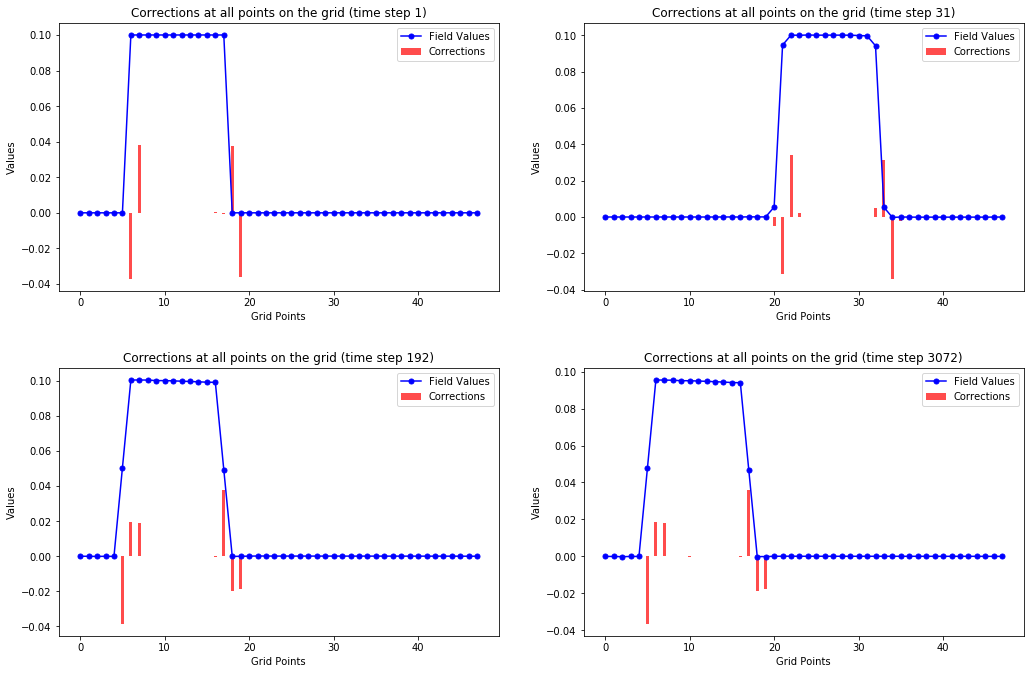

In [42]:
initial_condition_index = 1
resulting_states_np = resulting_states
resulting_corrects_np = resulting_corrects


time_indices = [0, 30, 191, 3071]
resulting_corrects_np_adjusted = resulting_corrects_np.transpose(2, 0, 1)  # [3072, 30, 48]

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()  # Flatten the array to easily iterate over it

for ax, t in zip(axs, time_indices):
    field_values = resulting_states_np[t, initial_condition_index, :]
    corrections = resulting_corrects_np_adjusted[t, initial_condition_index, :]

    ax.plot(np.arange(len(field_values)), field_values, 'o-', color='blue', label='Field Values', markerfacecolor='b', markeredgecolor='b', markersize=5)
    
    ax.bar(np.arange(len(corrections)), corrections, width=0.35, label='Corrections', color='red', alpha=0.7)

    ax.set_xlabel('Grid Points')
    ax.set_ylabel('Values')
    ax.set_title(f'Corrections at all points on the grid (time step {t+1})')
    ax.legend()

fig.tight_layout(pad=3.0)


In [44]:
time_steps = np.arange(0,16*192+1)


def wrap_as_xarray(integrated):
  dr = xarray.DataArray(
      integrated.numpy(),
      dims = ('time', 'sample', 'x'),
      coords = {'time': time_steps, 'x': x_coarse}
  )
  return dr


dr_nn = wrap_as_xarray(resulting_states)
dr_nn.sizes

Frozen({'time': 3073, 'sample': 30, 'x': 48})

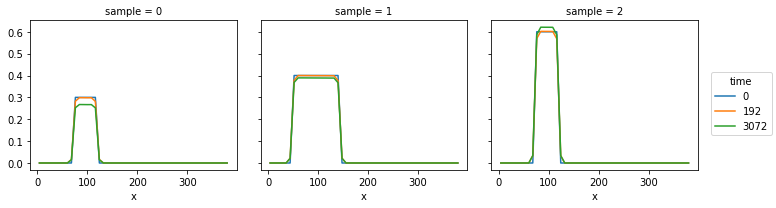

In [45]:
dr_nn.isel(time=[0,192,3072], sample=[6, 10, 15]).plot(col='sample', hue='time')


# Comparison with low-res and high-res simulation

## -Single IC plot, many time_steps




In [46]:
low_steps = np.arange(0, 16*192+1)
x_low = np.arange(0,384,8)

def wrap_as_xarray_single(integrated):
  dr = xarray.DataArray(
      integrated,
      dims = ('time', 'x'),
      coords = {'time': low_steps, 'x': x_coarse} 
  )
  return dr



## -------- Scaled IC, offseted, different width, extrapolation in time

In [47]:
high_res_off =  0.65*tf.roll(np.load('high_res_simul384_width.npy'),shift=10,axis=2)
low_res_off =  0.65*tf.roll(np.load('low_res_simul384_width.npy'),shift=10,axis=2)
concentration1_width = np.load('concentration1_width.npy')



initial_cond2 = concentration1_width[0:30]
initial_cond3 = 0.65*initial_cond2
initial_cond4 = tf.roll(initial_cond3,shift=10,axis=1)



high_res_off.shape, low_res_off.shape, initial_cond4.shape

(TensorShape([3073, 30, 48]),
 TensorShape([3073, 30, 48]),
 TensorShape([30, 48]))

In [48]:
%time resulting_states_3= forward_in_time(initial_state = initial_cond4, time_steps =time_steps,quantum_steps=4)
resulting_states_3.shape


CPU times: user 6.09 s, sys: 906 ms, total: 7 s
Wall time: 3.24 s


TensorShape([3073, 30, 48])

In [50]:
IC_ind = 12 
# IC_ind = 0 #the worst (out of training distr)

dr_low_single_off = wrap_as_xarray_single(low_res_off[:,IC_ind,:])
dr_high_single_off = wrap_as_xarray_single(high_res_off[:,IC_ind,:])
dr_nn_single_off = wrap_as_xarray_single(resulting_states_3[:,IC_ind,:])

dr_low_single_off.sizes,dr_high_single_off.sizes,dr_nn_single_off.sizes

(Frozen({'time': 3073, 'x': 48}),
 Frozen({'time': 3073, 'x': 48}),
 Frozen({'time': 3073, 'x': 48}))

In [51]:
dr_all_singleIC_off = xarray.concat([dr_nn_single_off, dr_low_single_off, dr_high_single_off], dim='model')

dr_all_singleIC_off.coords['model'] = ['hybrid', '2nd-order[superbee],coarse','2nd-order[superbee],fine']


Text(0.5,1.03,'Performance of the Hybrid Solver in time: out-of-sample IC, translated and interpolated in scale')

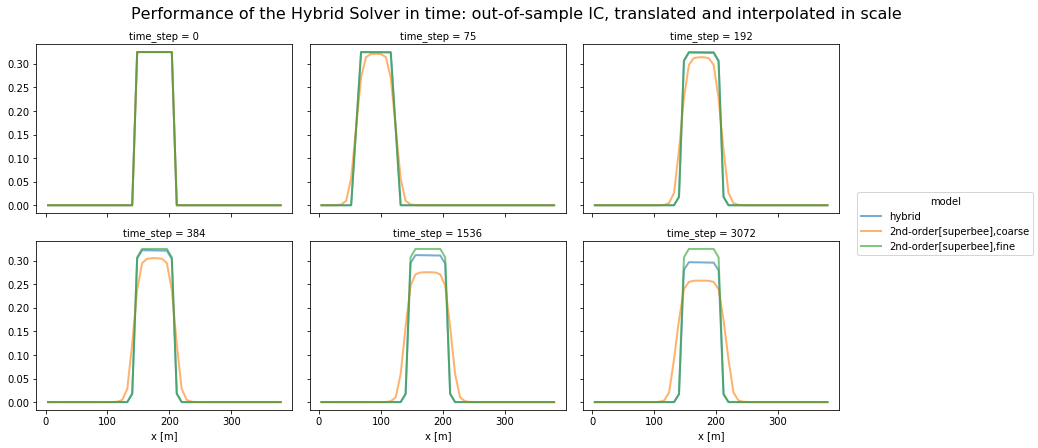

In [53]:
T = 96
(dr_all_singleIC_off.isel(time=[0, 75, 2*T,
                                4*T,16*T, 32*T
                            ])
.rename({'time': 'time_step','x': 'x [m]'}).plot(hue='model', col='time_step',col_wrap=3, alpha=0.6, linewidth=2,figsize=[12, 2*3])
)

plt.suptitle('Performance of the Hybrid Solver in time: out-of-sample IC, translated and interpolated in scale', y=1.03, fontsize=16)



In [54]:
lo = low_res_off
hi = high_res_off
my = resulting_states_3

sample_inf =6 # remove first dummy samples, 1st height is out of training distr, 2nd height also typically does not work well
sample_sup =30
time_sup =16*192

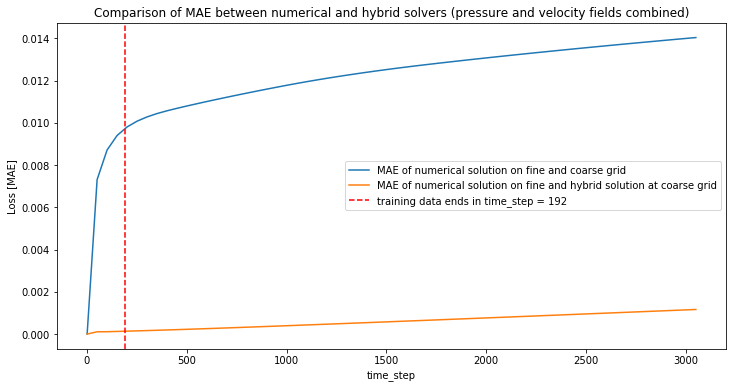

In [55]:
### SCALED BY HEIGHTS BEFORE CALCULATING MAE FOR EACH SQ. WAVE GIVES SAME RESULTS, (THEY ARE NORMALIZED EITHER WAY)

time_sup_values = range(1, 16*192,50)  # Example: from 1 to 50

l1_values = []
l2_values = []

# Iterate over the range of time_sup values
for time_sup in time_sup_values:
    l1 = tf.keras.losses.MeanAbsoluteError()(lo[:time_sup, sample_inf:sample_sup, :], hi[:time_sup, sample_inf:sample_sup, :])
    l2 = tf.keras.losses.MeanAbsoluteError()(my[:time_sup, sample_inf:sample_sup, :], hi[:time_sup, sample_inf:sample_sup, :])

    l1_values.append(l1.numpy())  
    l2_values.append(l2.numpy())


    
plt.figure(figsize=(12, 6))
plt.plot(time_sup_values, l1_values, label='MAE of numerical solution on fine and coarse grid')
plt.plot(time_sup_values, l2_values, label='MAE of numerical solution on fine and hybrid solution at coarse grid')

plt.axvline(x=192, color='r', linestyle='--', label='training data ends in time_step = 192')


plt.xlabel('time_step')
plt.ylabel('Loss [MAE]')
plt.title('Comparison of MAE between numerical and hybrid solvers (pressure and velocity fields combined)')
plt.legend()
